#### Cross Validation:
is a way we can further split up our data to find the best model, or the hyper parameters for a model.
#### K-Fold Cross Validation¶
##### main idea: split your data into k (a positive integer) folds.
treat each fold a s a test split and average model's performace across all folds
##### Pros:
works for any tupe of model
important for datasets w/ small n
##### Cons:
computationally expensive, especially as k increases
##### leave one out cross valiation: k = n-1
#### Dataset w/ k=3:
    
- k1
    - Train: A, B 
    - Test: C 
    - Score: 0.68
__________
- k2    
    - Train: A, C
    - Test: B
    - Score: 0.75
___________
- k3    
    - Train: C, B
    - Test: A
    - Score: 0.72
            
| K | Train    |  Test    | Score |
|---|----------|----------|-------|
| 1 | A, B     |    C     | 0.68  | 
| 2 | A, C     |    B     | 0.75  | 
| 3 | C, B     |    A     | 0.72  | 


Avg Test Score = (0.68+0.75+ 0.72) / 3 = 71.67%
  - there is no correct value for 'k' but most common is 5
  - score is on accuracy unless otherwise specified

#### Grid Search
- helps you determine what 'k' to use
- compares hyperparameters

<div style="display: grid; grid-template-columns: repeat(4, 1fr); gap: 1em;">
    <div style="background: blue;"></div>
</div>

## Setup

We'll use the mpg dataset and predict whether a car has automatic or manual transmission.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydataset

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
mpg = pydataset.data('mpg')
mpg.trans = np.where(mpg.trans.str.startswith('auto'), 'auto', 'manual')

In [3]:
X, y = mpg[['displ', 'cyl', 'cty', 'hwy']], mpg.trans

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

## `.cross_val_score`

In [5]:
clf = DecisionTreeClassifier(max_depth=4)
cross_val_score(clf, X_train, y_train, cv=5).mean()

0.6114285714285714

<AxesSubplot:xlabel='depth'>

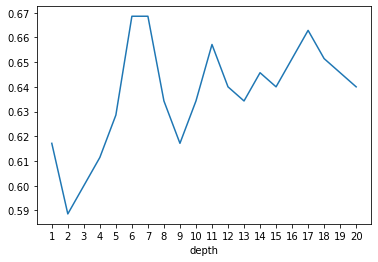

In [6]:
results = []
for depth in range(1, 21):
    clf = DecisionTreeClassifier(max_depth=depth)
    result = {'depth': depth}
    result['score'] = cross_val_score(clf, X_train, y_train, cv=5).mean()
    results.append(result)
        
pd.DataFrame(results).set_index('depth').score.plot(xticks=range(1, 21))

## Grid Search

### KNN Model

In [14]:
#create model
clf = KNeighborsClassifier()

#specify the parameters (all hyperparams in n neighbors, range 1-20)
params = {'n_neighbors': range(1, 21)}

#create a grid search
grid = GridSearchCV(clf, params, cv=5)

#fit the model
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 21)})

In [15]:
# np array of all mean test scores
grid.cv_results_['mean_test_score']

array([0.59428571, 0.62857143, 0.60571429, 0.62857143, 0.61142857,
       0.61142857, 0.57142857, 0.62285714, 0.6       , 0.64      ,
       0.62285714, 0.65142857, 0.62857143, 0.62285714, 0.64      ,
       0.64      , 0.65142857, 0.63428571, 0.61714286, 0.64      ])

In [16]:
grid.cv_results_['params']

[{'n_neighbors': 1},
 {'n_neighbors': 2},
 {'n_neighbors': 3},
 {'n_neighbors': 4},
 {'n_neighbors': 5},
 {'n_neighbors': 6},
 {'n_neighbors': 7},
 {'n_neighbors': 8},
 {'n_neighbors': 9},
 {'n_neighbors': 10},
 {'n_neighbors': 11},
 {'n_neighbors': 12},
 {'n_neighbors': 13},
 {'n_neighbors': 14},
 {'n_neighbors': 15},
 {'n_neighbors': 16},
 {'n_neighbors': 17},
 {'n_neighbors': 18},
 {'n_neighbors': 19},
 {'n_neighbors': 20}]

In [17]:
# this will tell you n-12 has the best score with 0.65
grid.best_score_, grid.best_params_

(0.6514285714285715, {'n_neighbors': 12})

In [18]:
# this only shows the best n
knn_model = grid.best_estimator_

### Decision Tree Model

In [19]:
#create model
clf = DecisionTreeClassifier()

#identify parameters
params = {'max_depth': range(1, 21), 'min_samples_leaf': range(1, 11)}

#create grid search
grid = GridSearchCV(clf, params, cv=10)

#fit model
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 21),
                         'min_samples_leaf': range(1, 11)})

In [20]:
# combine results with params and turn it into Pandas DF
for params, score in zip(grid.cv_results_['params'], grid.cv_results_['mean_test_score']):
    params['score'] = score

In [21]:
# Create DF with results of cross validation scores
pd.DataFrame(grid.cv_results_['params']).sort_values(by='score').tail(10)

,max_depth,min_samples_leaf,score
90,10,1,0.701961
170,18,1,0.706863
150,16,1,0.706863
80,9,1,0.707516
130,14,1,0.707516
160,17,1,0.712745
190,20,1,0.713072
120,13,1,0.713072
110,12,1,0.718954
180,19,1,0.724510


## Custom Scoring

In [22]:
from sklearn.metrics import make_scorer, precision_score

clf = KNeighborsClassifier(n_neighbors=5)
cross_val_score(
    clf, 
    X_train, 
    y_train, 
    scoring=make_scorer(precision_score, pos_label='manual')
)

array([0.45454545, 0.625     , 0.36363636, 0.33333333, 0.42857143])